# EVN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 단어 긍정(2), 중립(1), 부정(0) 분류 프로젝트

## 데이터

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [[1, 1, 1, 2],
          [1, 1, 0]]  # 긍정(2), 중립(1), 부정(0)

# 정답 dic
id_to_label = {0: '부정', 1: '중립', 2: '긍정'}

In [ ]:
id_to_label[2]

'긍정'

In [ ]:
sentences

['나는 오늘 기분이 좋아', '나는 오늘 우울해']

In [ ]:
labels

[[1, 1, 1, 2], [1, 1, 0]]

## Vocabulary

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는', '오늘', '기분이', '좋아']
['나는', '오늘', '우울해']


['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [ ]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해']

In [ ]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}  # PAD 길이를 조절할때, UNK vocab에 없는 단어
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [ ]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'}

## 모델 학습용 데이터 생성

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])
train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [ ]:
# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_inputs

(2, 4)

In [ ]:
# train label은 labels를 그래도 사용
train_labels = labels
train_labels

[[1, 1, 1, 2], [1, 1, 0]]

In [ ]:
# 정답 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_labels:
    row += [1] * (4 - len(row))
train_labels

[[1, 1, 1, 2], [1, 1, 0, 1]]

In [ ]:
# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)
train_labels

array([[1, 1, 1, 2],
       [1, 1, 0, 1]])

In [ ]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    동작만 하는 간단한 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)

    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    # 단어의 vector를 이용해서 정답 확률값 예측
    linear = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)
    outputs = linear(hidden)  # (bs, n_seq, n_out)
    
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

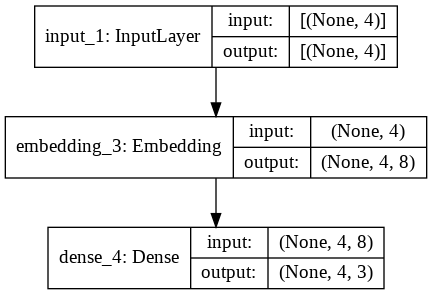

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 3)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 4, 8)              56        
_________________________________________________________________
dense_4 (Dense)              (None, 4, 3)              27        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


## 모델링

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 8)  # n_vocab, d_model
hidden = embedding(train_inputs)
train_inputs.shape, hidden

In [ ]:
# 단어의 vector를 이용해서 긍정(2), 부정(0), 중립(1) 확률값 예측
linear = tf.keras.layers.Dense(3, activation=tf.nn.softmax)
outputs = linear(hidden)
outputs

In [ ]:
# 단어의 vector를 이용해서 긍정(2), 부정(0), 중립(1) 확률값 예측
linear_2 = tf.keras.layers.Dense(3)
logits = linear_2(hidden)
logits

In [ ]:
# softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits)
denominator = np.sum(numerator, axis=2, keepdims=True)
numerator, denominator

In [ ]:
# 두 결과값 비교
probs = numerator / denominator
probs

In [ ]:
# dense의 wieght, bias
weight, bias = linear_2.get_weights()
weight, bias

In [ ]:
# numpy를 이용한 xW + b
logits = np.matmul(hidden, weight) + bias
logits

## 학습

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels, epochs=100, batch_size=16)

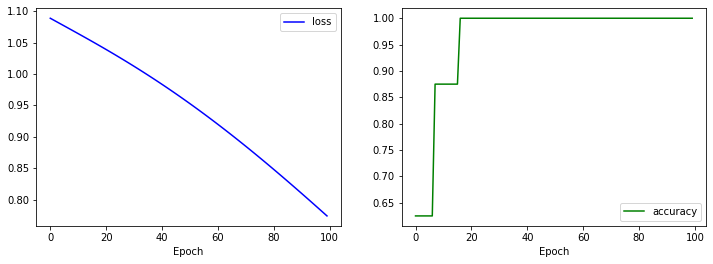

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 평가

In [ ]:
# 모델 평가
model.evaluate(train_inputs, train_labels)

1/1 [==============================] - 0s 169ms/step - loss: 0.7700 - accuracy: 1.0000


[0.7699621915817261, 1.0]

## 예측

In [ ]:
# 추론할 입력
string = '나는 기분이 우울해'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
infer_input += [0] * (4 - len(infer_input))
infer_input

In [ ]:
# numpy array 변환 (batch size 1 추가)
infer_inputs = np.array([infer_input])
infer_inputs

In [ ]:
# 긍정/부정 추론
y_preds = model.predict(infer_inputs)
y_preds

In [ ]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=2)
y_pred_class